In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

2025-09-04 16:51:33.334333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757004693.723513      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757004693.834610      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_set_path = "/kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification"
data_set_train_path = os.path.join(data_set_path, "train_images")
print(data_set_train_path)
data_set_test_path = os.path.join(data_set_path, "test_images")

/kaggle/input/new-paddy-doctor-paddy-disease-classification/paddy-disease-classification/train_images


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
TRAIN_DATA_SIZE = 0.8
TEST_DATA_SIZE = 0.05
VALIDATION_DATA_SIZE = 0.15
CHANDIM = -1

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19131 files belonging to 10 classes.


I0000 00:00:1757004738.850807      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757004738.851512      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data Visualization

In [5]:
class_names = train_dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [6]:
def calculate_class_counts(dataset,folder_path):
  class_names = dataset.class_names
  class_counts = {}
  for class_name in class_names:
    class_dir = os.path.join(folder_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))
  return class_counts

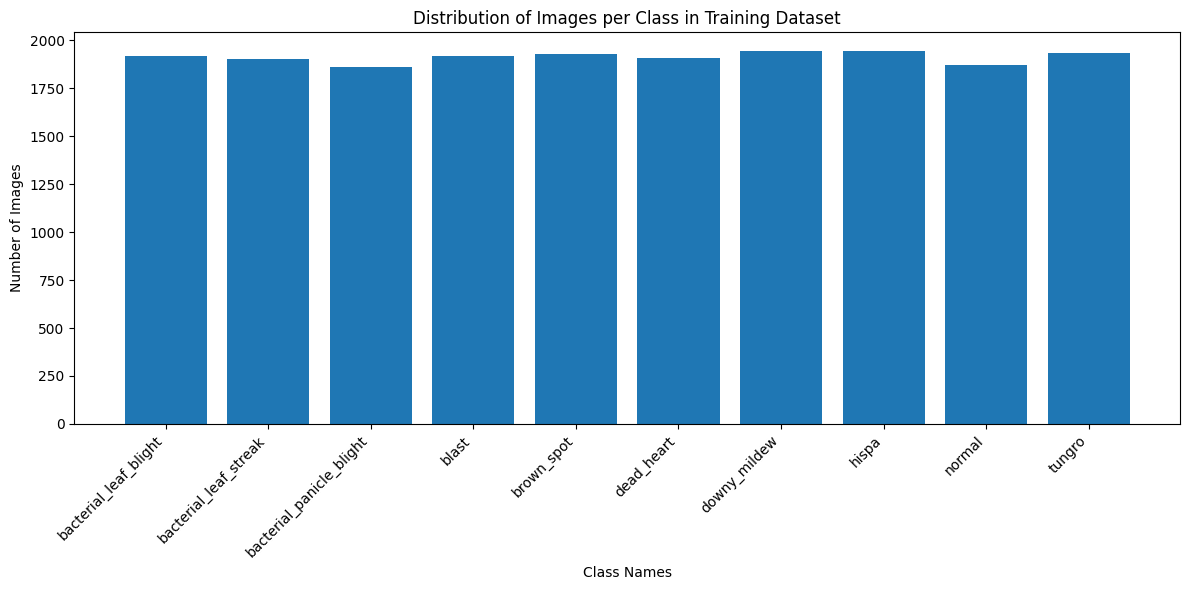

In [7]:
train_dataset_class_counts = calculate_class_counts(train_dataset,data_set_train_path)
plt.figure(figsize=(12, 6))
plt.bar(train_dataset_class_counts.keys(), train_dataset_class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

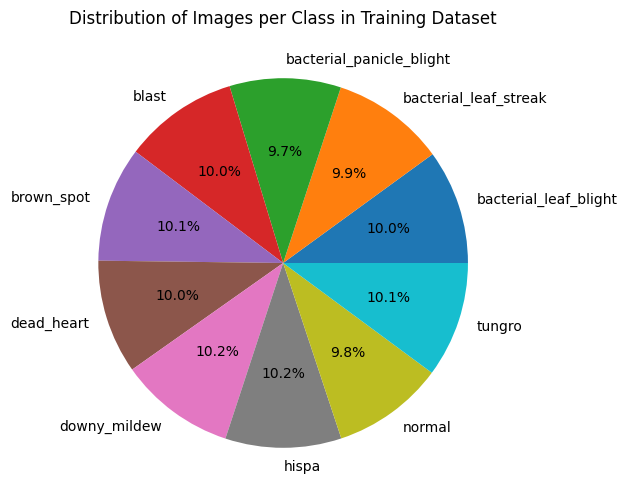

In [8]:
plt.figure(figsize=(12, 6))
plt.pie(train_dataset_class_counts.values(), labels=train_dataset_class_counts.keys(), autopct='%1.1f%%')
plt.title("Distribution of Images per Class in Training Dataset")
plt.show()

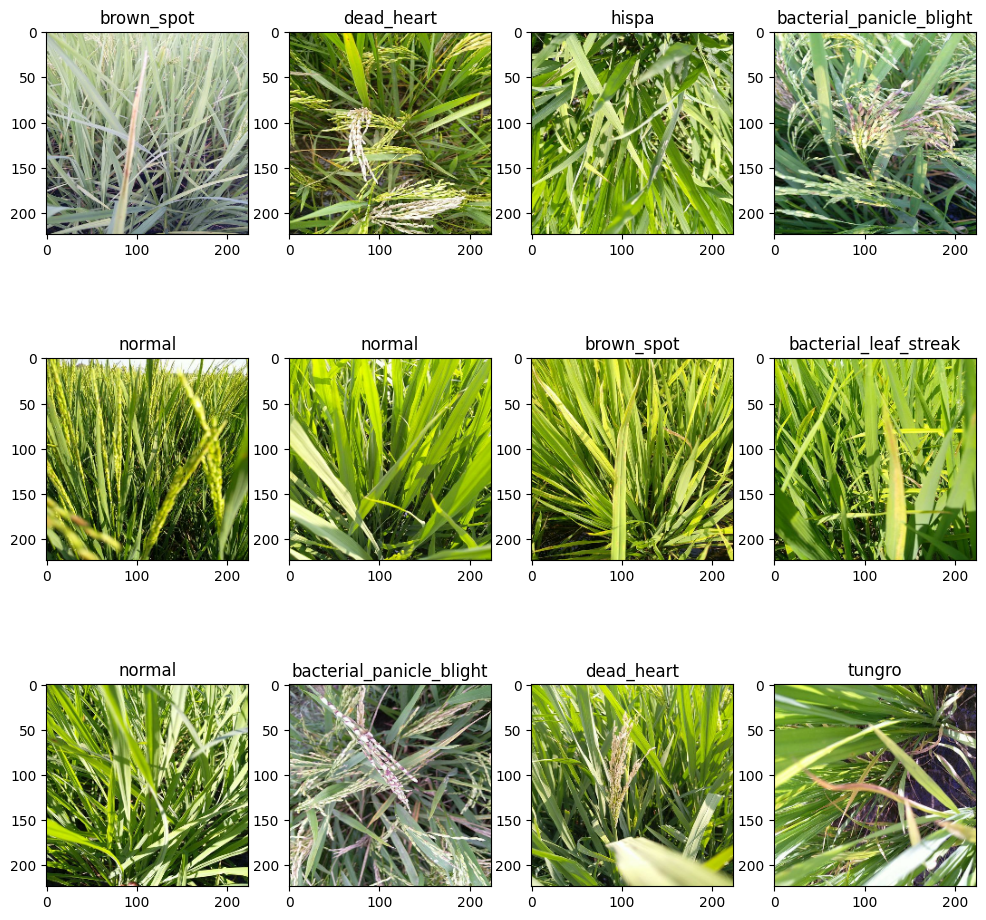

In [9]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

# visiualize pre splitted test data


In [10]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


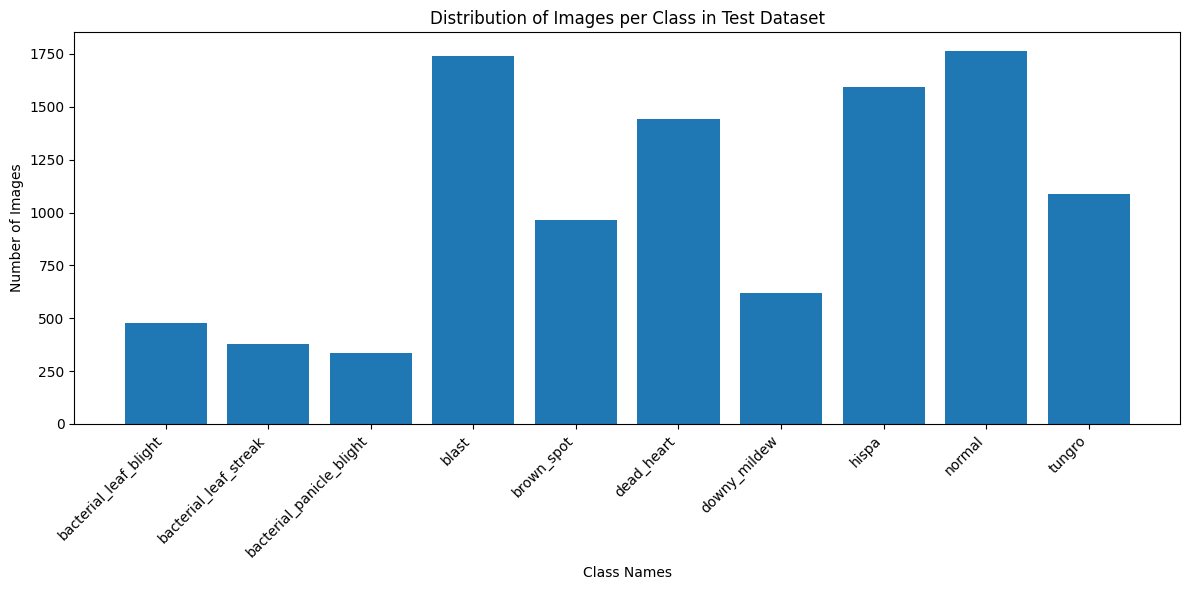

In [11]:
test_data_class_count = calculate_class_counts(test_data,data_set_test_path)
plt.figure(figsize=(12, 6))
plt.bar(test_data_class_count.keys(), test_data_class_count.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Test Dataset")
plt.tight_layout()
plt.show()

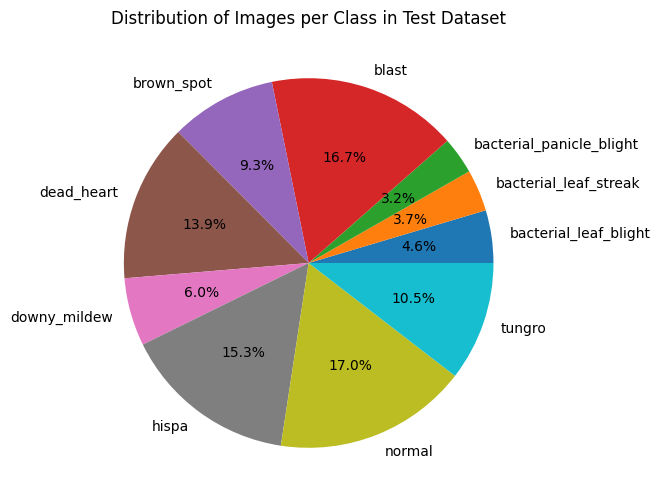

In [12]:
plt.figure(figsize=(12, 6))
plt.pie(test_data_class_count.values(), labels=test_data_class_count.keys(), autopct='%1.1f%%')
plt.title("Distribution of Images per Class in Test Dataset")
plt.show()

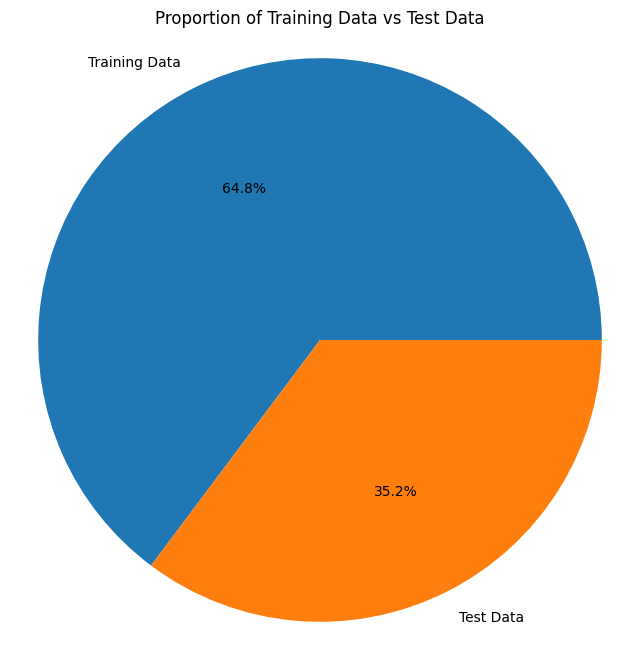

In [13]:
total_train_images = sum(train_dataset_class_counts.values())
total_test_images = sum(test_data_class_count.values())

labels = ['Training Data', 'Test Data']
sizes = [total_train_images, total_test_images]
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title("Proportion of Training Data vs Test Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# check pre defined test data are same or not

In [14]:
def extract_file_names_from_dataset(data_test_classes,data_set_path):
  train_data_names = []
  for class_name in data_test_classes:
      train_data_names.extend(os.listdir(os.path.join(data_set_path,class_name)))
  return set(train_data_names)

is_smae =  extract_file_names_from_dataset(train_dataset.class_names,data_set_train_path).intersection(extract_file_names_from_dataset(test_data.class_names,data_set_test_path))
if is_smae:
  print("test data and train data are same")
else:
  print("test data and train data are not same")

test data and train data are same


In [15]:
len(train_dataset)

598

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(train_dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,validation_ds,test_ds

In [17]:
train_ds,validation_ds,test_ds = get_dataset_partitions_tf(train_dataset,TRAIN_DATA_SIZE,VALIDATION_DATA_SIZE,TEST_DATA_SIZE)

In [18]:
len(train_ds),len(validation_ds),len(test_ds)

(478, 89, 31)

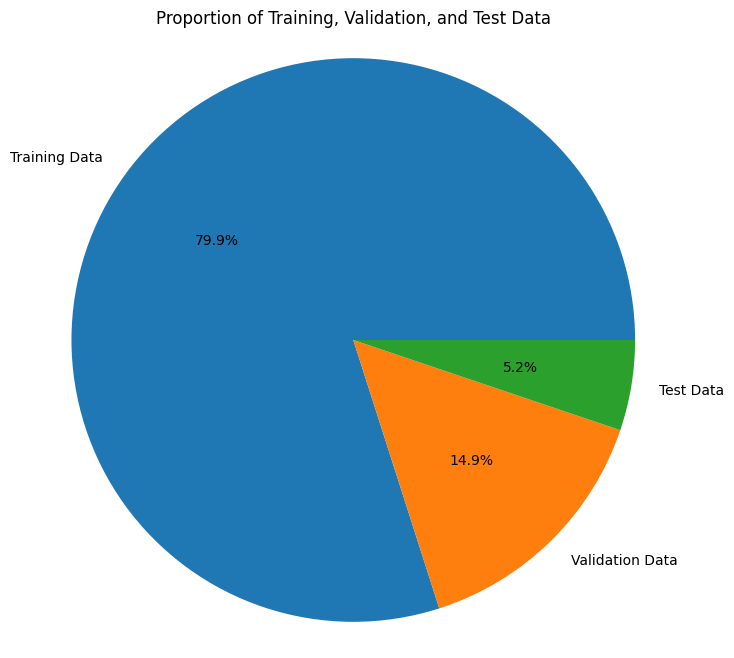

In [19]:
labels = ['Training Data', 'Validation Data', 'Test Data']
sizes = [len(train_ds), len(validation_ds), len(test_ds)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)
plt.title("Proportion of Training, Validation, and Test Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Datasets optimization

In [20]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Image preprocessing

In [21]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Model Build

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    # Block 1
    layers.Conv2D(32, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Dropout(0.25),
    
    # Block 2
    layers.Conv2D(64, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    
    layers.Conv2D(64, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),

    layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
    layers.BatchNormalization(axis=CHANDIM),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(1024),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(len(class_names), activation='softmax')

])

In [24]:
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 224, 224, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 224, 224, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 74, 74, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 74, 74, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 74, 74, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 74, 74, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 74, 74, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32, 74, 74, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 37, 37, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 37, 37, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 37, 37, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32, 37, 37, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 37, 37, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (32, 37, 37, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 18, 18, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 18, 18, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 41472)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │    42,468,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (32, 1024)             │         4,096 │
│ (BatchNormalization)            │                        │             

 Total params: 42,762,122 (163.12 MB)

 Trainable params: 42,759,242 (163.11 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Training

In [29]:
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_ds,
                    verbose=1,
                    epochs=EPOCHS
)

Epoch 1/50


E0000 00:00:1757004923.120760      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1757004985.526126     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


478/478 ━━━━━━━━━━━━━━━━━━━━ 167s 196ms/step - accuracy: 0.2242 - loss: 2.6989 - val_accuracy: 0.1633 - val_loss: 2.9548
Epoch 2/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 115s 196ms/step - accuracy: 0.4160 - loss: 1.8065 - val_accuracy: 0.4017 - val_loss: 1.9729
Epoch 3/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 115s 194ms/step - accuracy: 0.5326 - loss: 1.3817 - val_accuracy: 0.4431 - val_loss: 1.8400
Epoch 4/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 114s 194ms/step - accuracy: 0.6024 - loss: 1.1746 - val_accuracy: 0.5046 - val_loss: 1.7711
Epoch 5/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 113s 194ms/step - accuracy: 0.6706 - loss: 0.9680 - val_accuracy: 0.3461 - val_loss: 3.9447
Epoch 6/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 120s 196ms/step - accuracy: 0.6936 - loss: 0.9112 - val_accuracy: 0.5916 - val_loss: 1.5491
Epoch 7/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 118s 205ms/step - accuracy: 0.7537 - loss: 0.7379 - val_accuracy: 0.3947 - val_loss: 3.6358
Epoch 8/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 121s 196ms/step - accuracy: 0.7697 - loss: 0.68

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

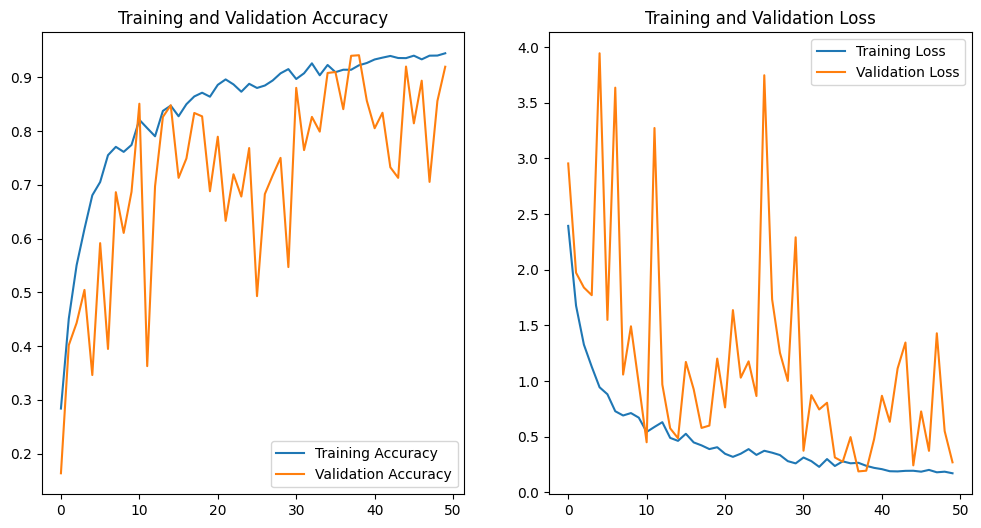

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: bacterial_panicle_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
predicted label: bacterial_panicle_blight


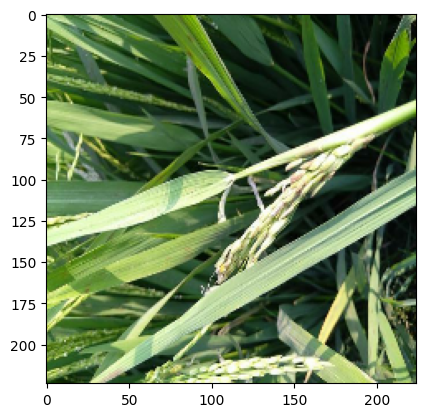

In [32]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model,image_array):
  img_array = tf.expand_dims(image_array, 0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


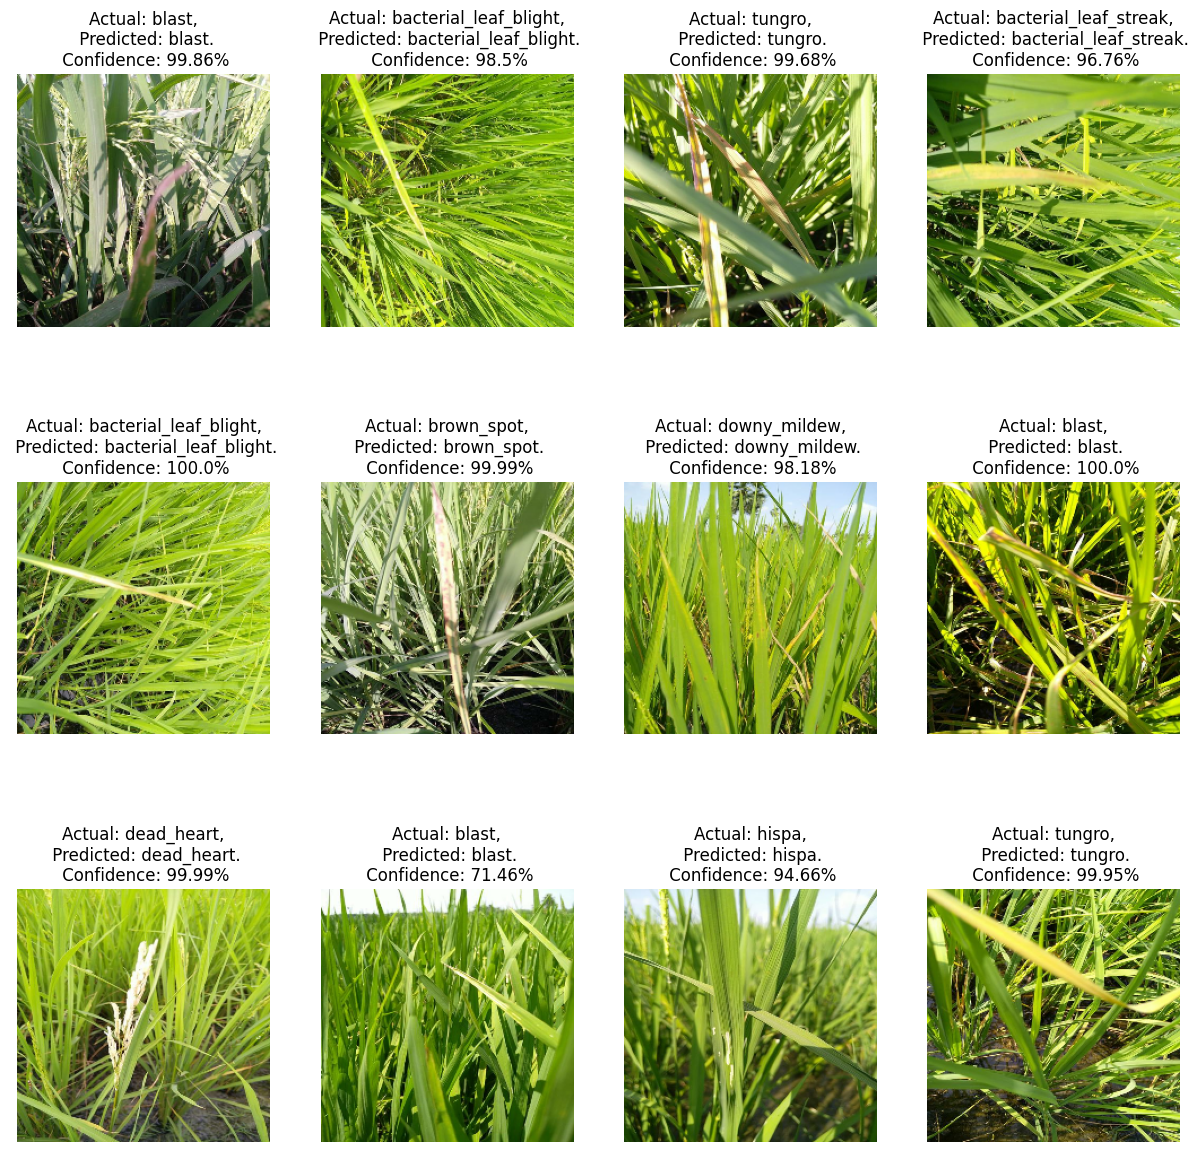

In [40]:
plt.figure(figsize=(15, 15))
for images,labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

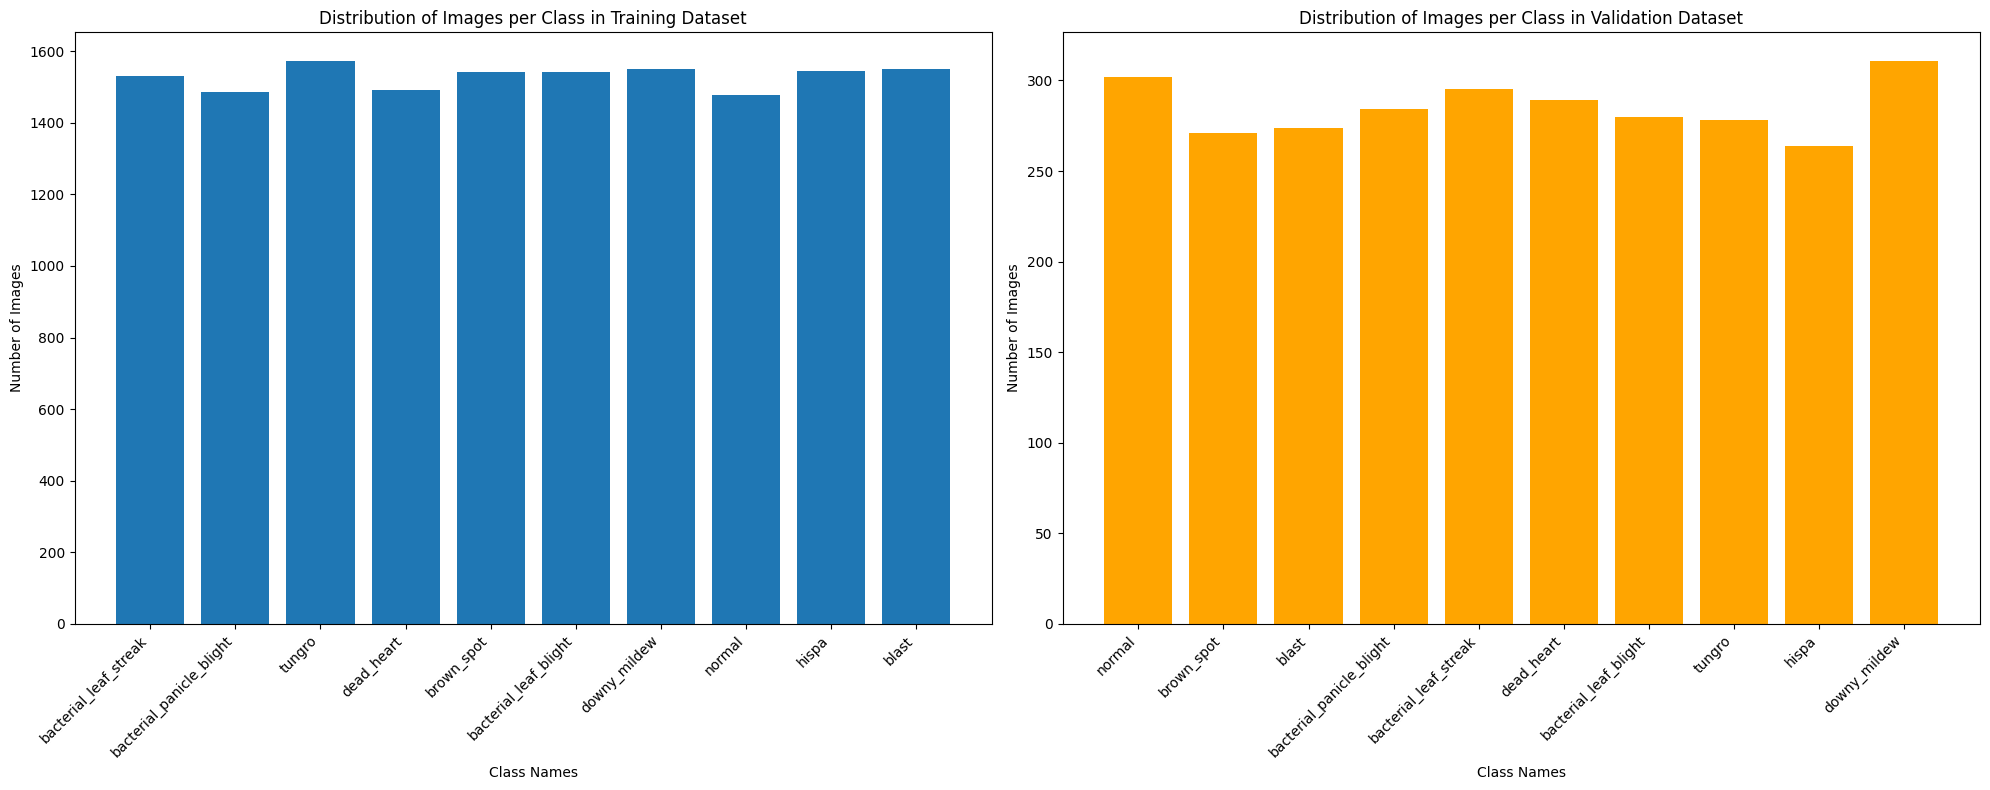

In [35]:
def calculate_class_counts(dataset):
    class_counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

# Calculate class counts for training and validation datasets
train_class_counts = calculate_class_counts(train_ds)
validation_class_counts = calculate_class_counts(validation_ds)

# Create a figure with two subplots for side-by-side charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Bar chart for training data
ax1.bar(train_class_counts.keys(), train_class_counts.values())
ax1.set_title('Distribution of Images per Class in Training Dataset')
ax1.set_xlabel('Class Names')
ax1.set_ylabel('Number of Images')
ax1.set_xticks(range(len(train_class_counts.keys())))
ax1.set_xticklabels(train_class_counts.keys(), rotation=45, ha='right')


# Bar chart for validation data
ax2.bar(validation_class_counts.keys(), validation_class_counts.values(), color='orange')
ax2.set_title('Distribution of Images per Class in Validation Dataset')
ax2.set_xlabel('Class Names')
ax2.set_ylabel('Number of Images')
ax2.set_xticks(range(len(validation_class_counts.keys())))
ax2.set_xticklabels(validation_class_counts.keys(), rotation=45, ha='right')

fig.tight_layout()
plt.show()

# Model Eveluation

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [37]:
test_labels = []
predicted_labels = []

for images, labels in test_ds:
    for label in labels.numpy():
        test_labels.append(label)
    for prediction in model.predict(images):
        predicted_labels.append(np.argmax(prediction))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

In [38]:
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))


Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.85      0.96      0.90       104
   bacterial_leaf_streak       0.93      0.99      0.96        99
bacterial_panicle_blight       0.92      1.00      0.96        97
                   blast       0.87      0.89      0.88       101
              brown_spot       0.93      0.88      0.91       103
              dead_heart       1.00      0.84      0.91        95
            downy_mildew       0.96      0.84      0.90        82
                   hispa       0.98      0.84      0.90        94
                  normal       0.91      0.98      0.95       109
                  tungro       0.86      0.90      0.88       108

                accuracy                           0.92       992
               macro avg       0.92      0.91      0.91       992
            weighted avg       0.92      0.92      0.91       992



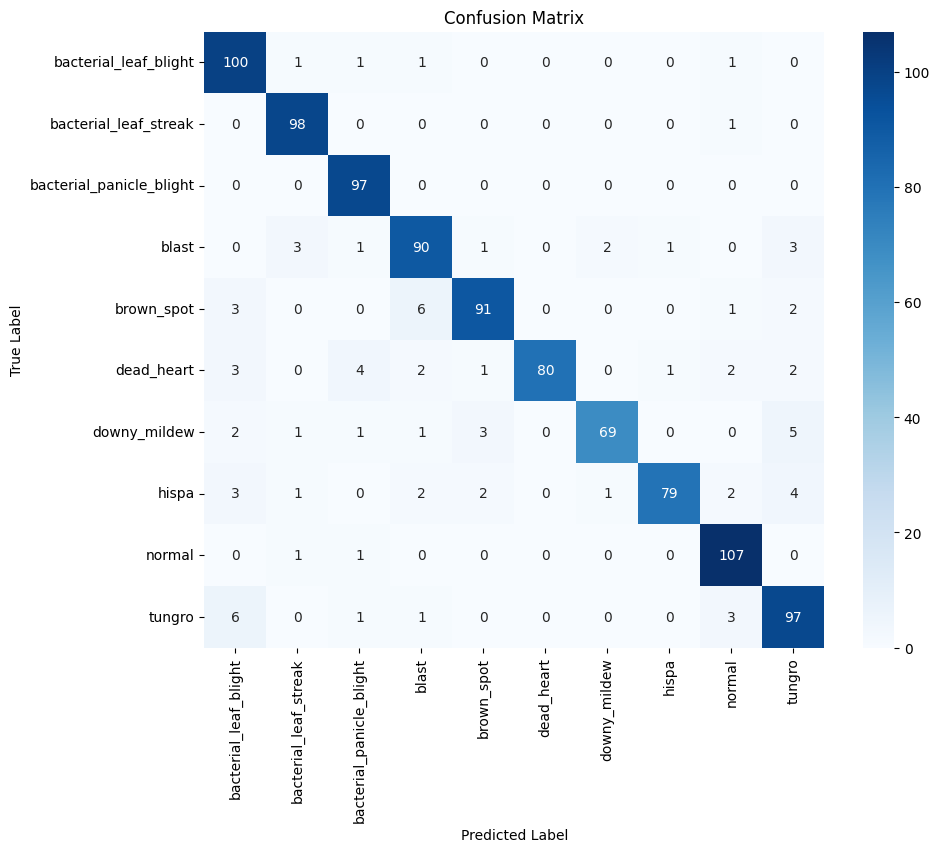

In [39]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()